In [1]:
import pandas as pd
import pandas_datareader as pddr
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor as xgbreg


import warnings
warnings.filterwarnings("ignore")

In [2]:
start_date = dt.datetime(1980, 1, 1)
end_date = dt.datetime.now()
stock_sticker = 'AAPL'

df = pddr.DataReader(stock_sticker, 'yahoo', start_date, end_date)

In [3]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1980-12-12,0.128906,0.128348,0.128348,0.128348,469033600.0,0.100178
1980-12-15,0.122210,0.121652,0.122210,0.121652,175884800.0,0.094952
1980-12-16,0.113281,0.112723,0.113281,0.112723,105728000.0,0.087983
1980-12-17,0.116071,0.115513,0.115513,0.115513,86441600.0,0.090160
1980-12-18,0.119420,0.118862,0.118862,0.118862,73449600.0,0.092774


In [4]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-07-29,163.630005,159.500000,161.240005,162.509995,101689200.0,162.509995
2022-08-01,163.589996,160.889999,161.009995,161.509995,67829400.0,161.509995
2022-08-02,162.410004,159.630005,160.100006,160.009995,59907000.0,160.009995
2022-08-03,166.589996,160.750000,160.839996,166.130005,82507500.0,166.130005
2022-08-04,167.190002,164.429993,166.009995,165.809998,55409400.0,165.809998


In [5]:
df.dtypes

High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Adj Close    float64
dtype: object

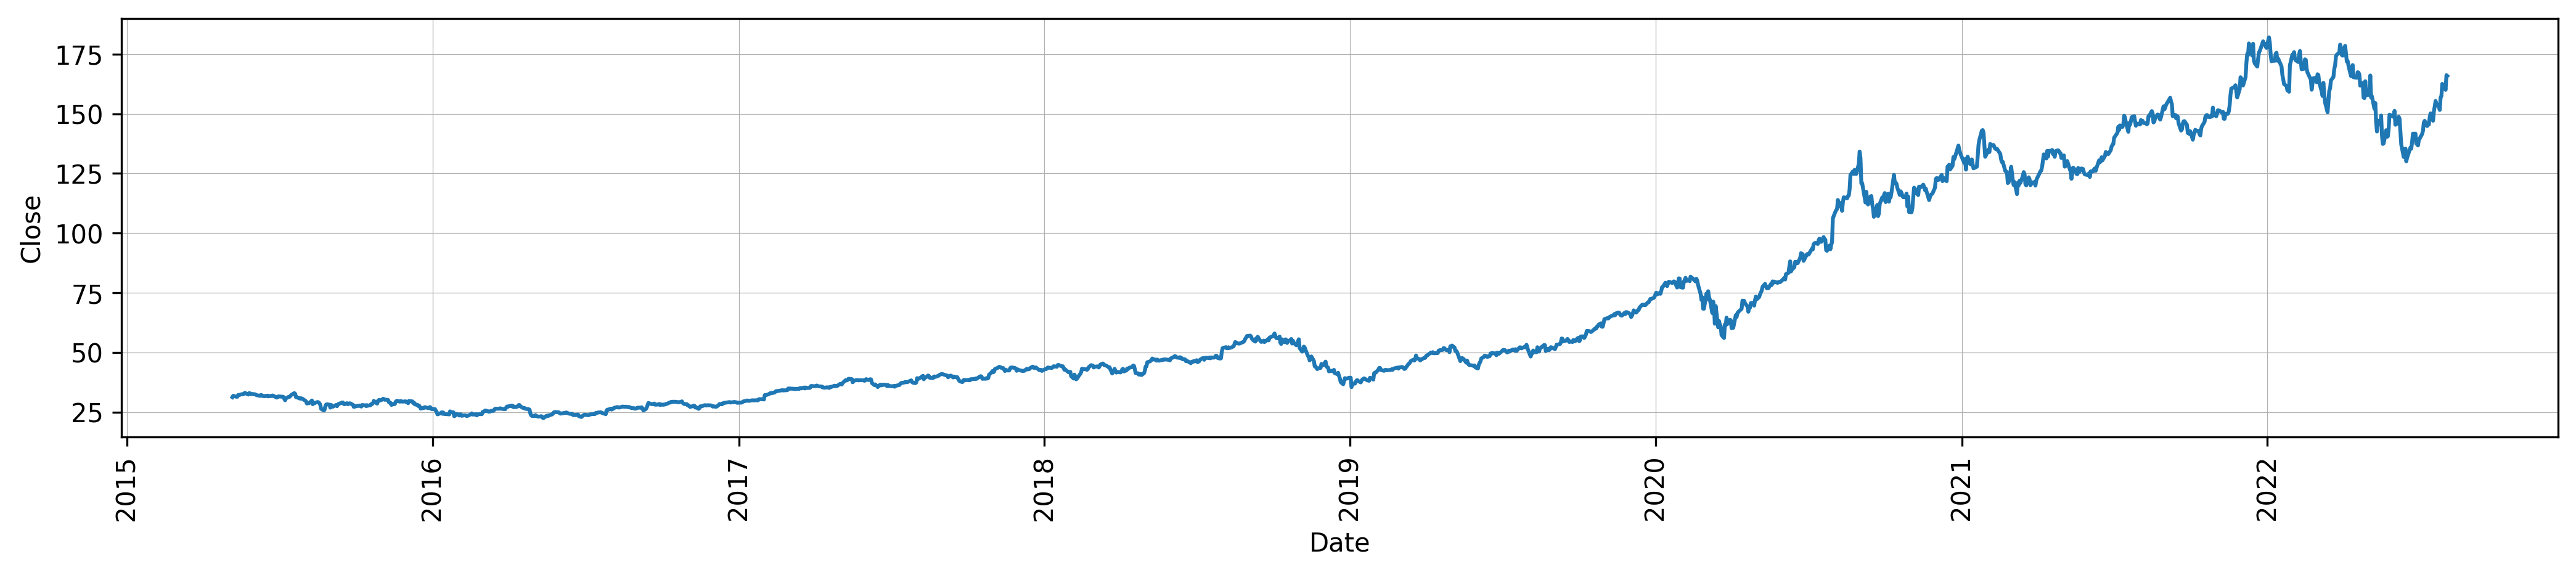

In [6]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=df.tail(1825), x=df.tail(1825).index, y='Close')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

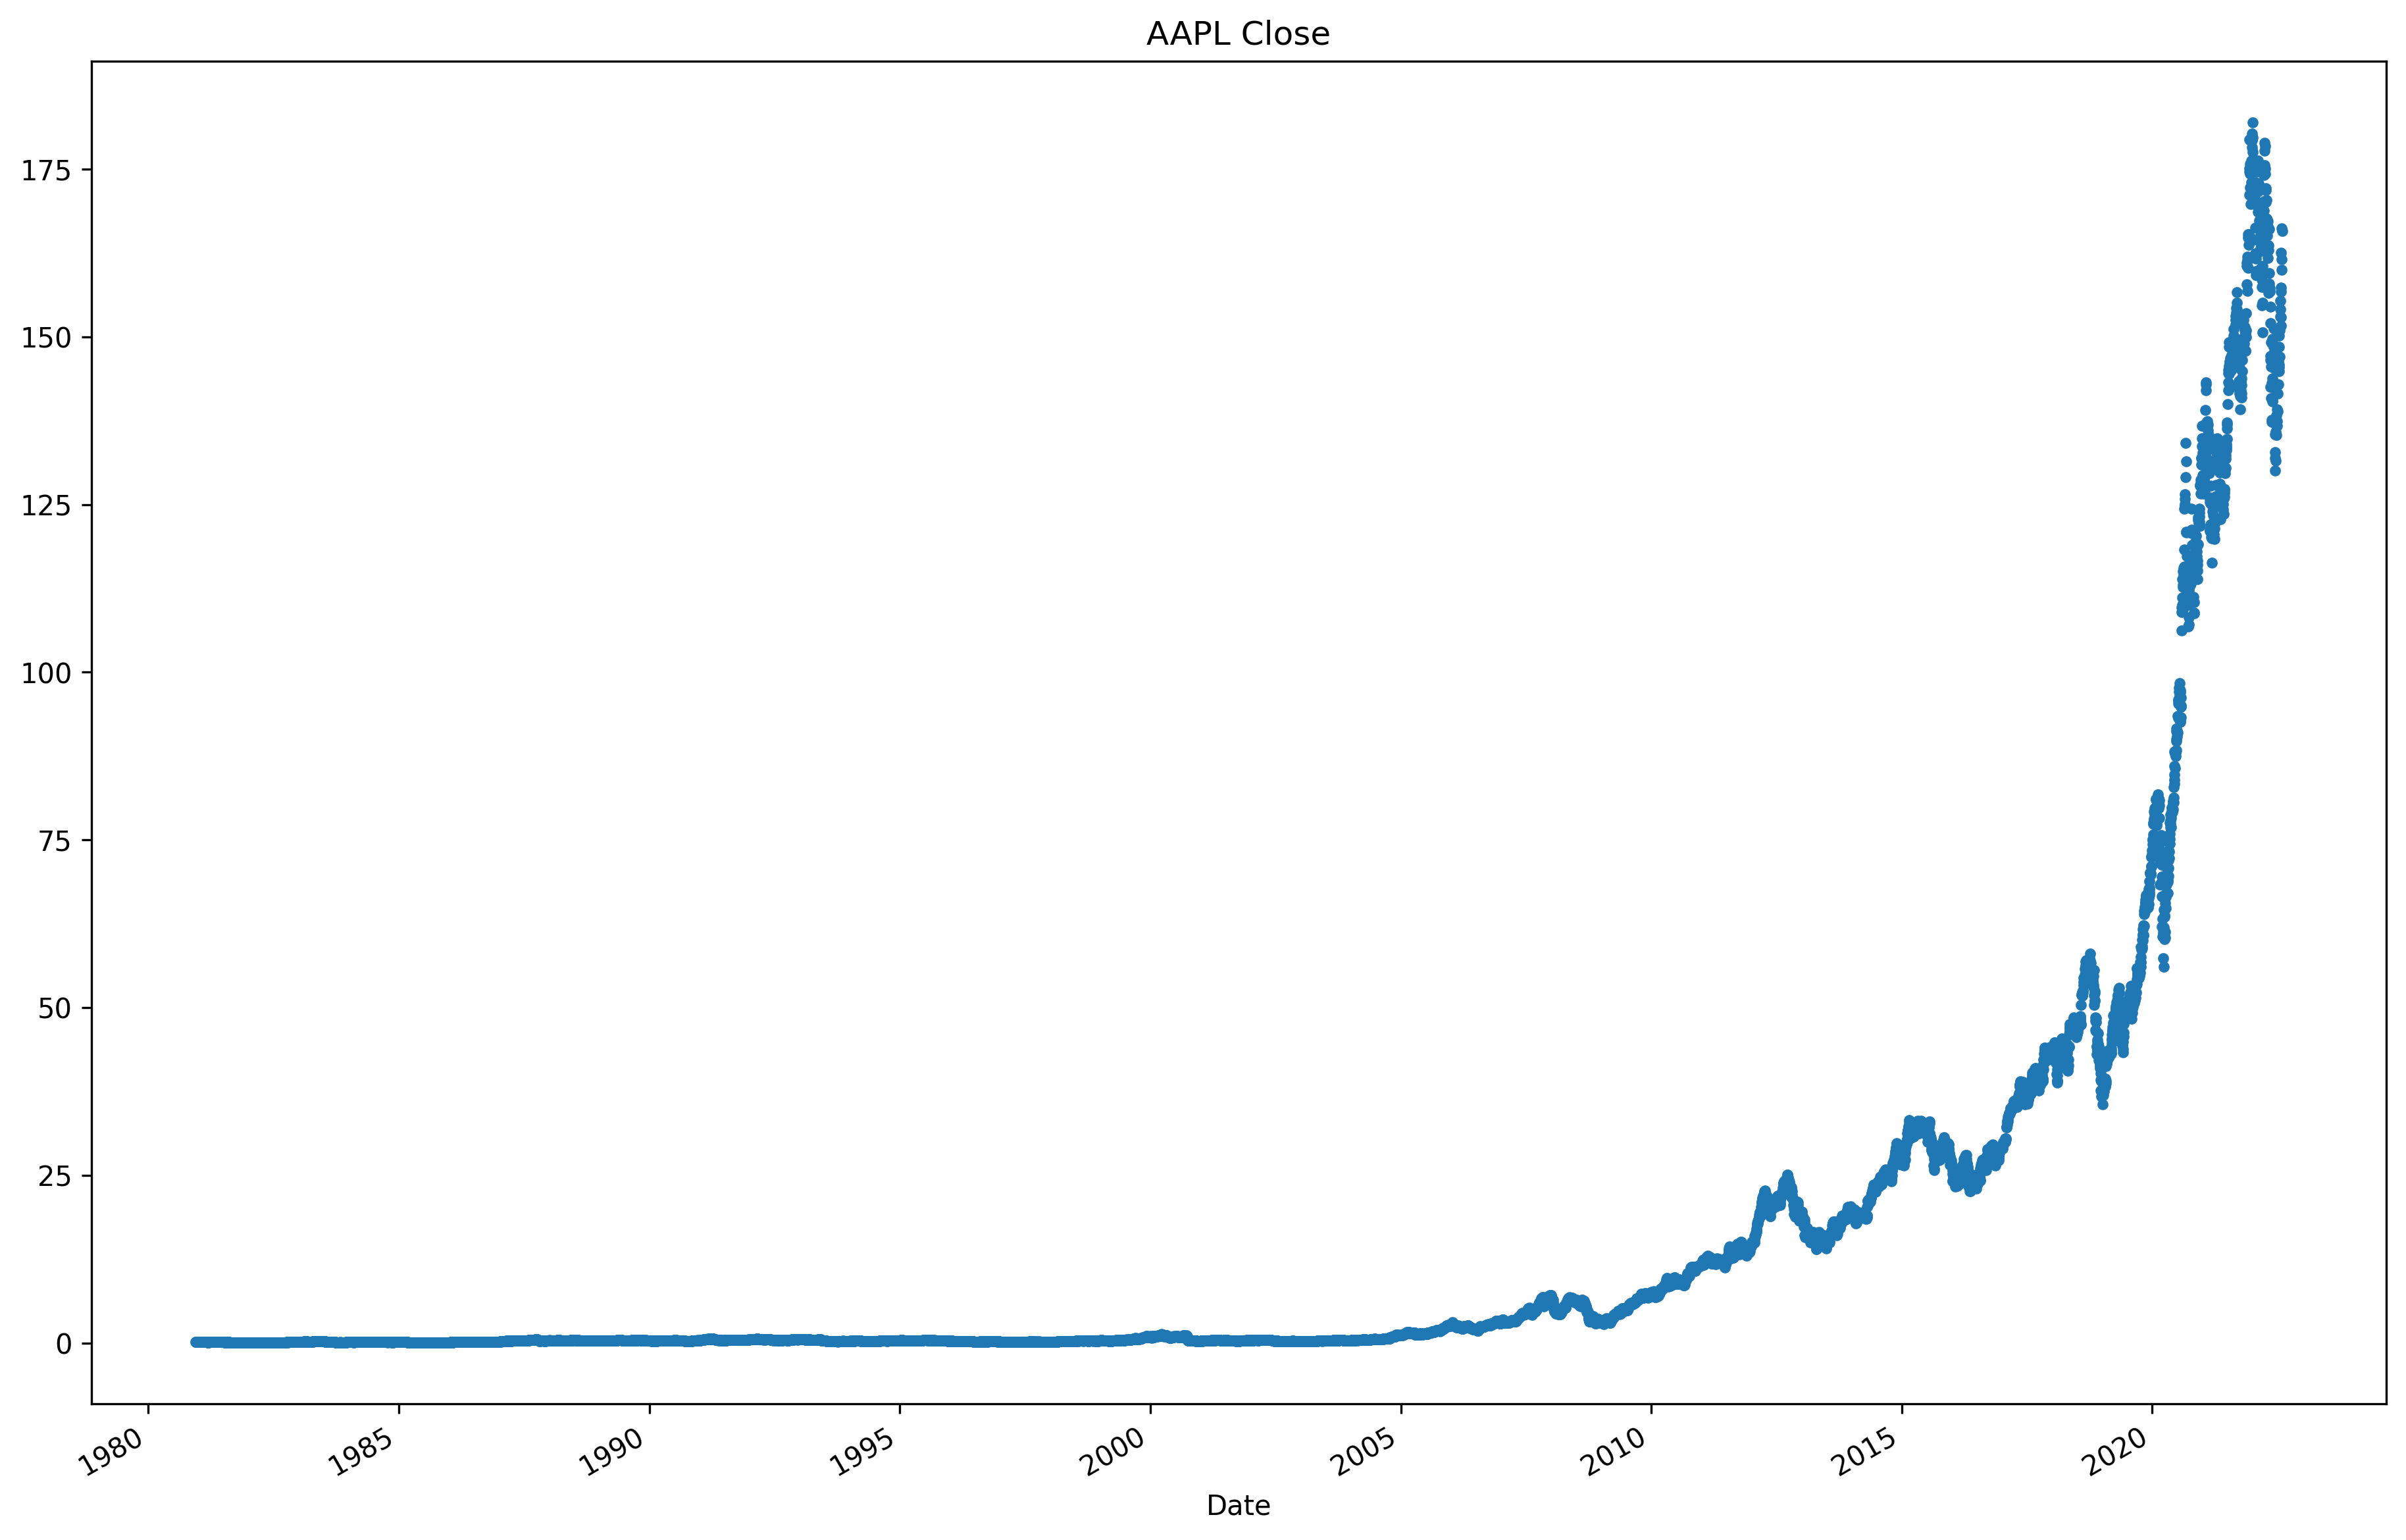

In [7]:
df['Close'].plot(style='.', figsize=(15, 10), title="AAPL Close")
plt.show()

In [8]:
data_split = '02-01-2022'
train_data = df.loc[df.index < data_split]
test_data = df.loc[df.index >= data_split]

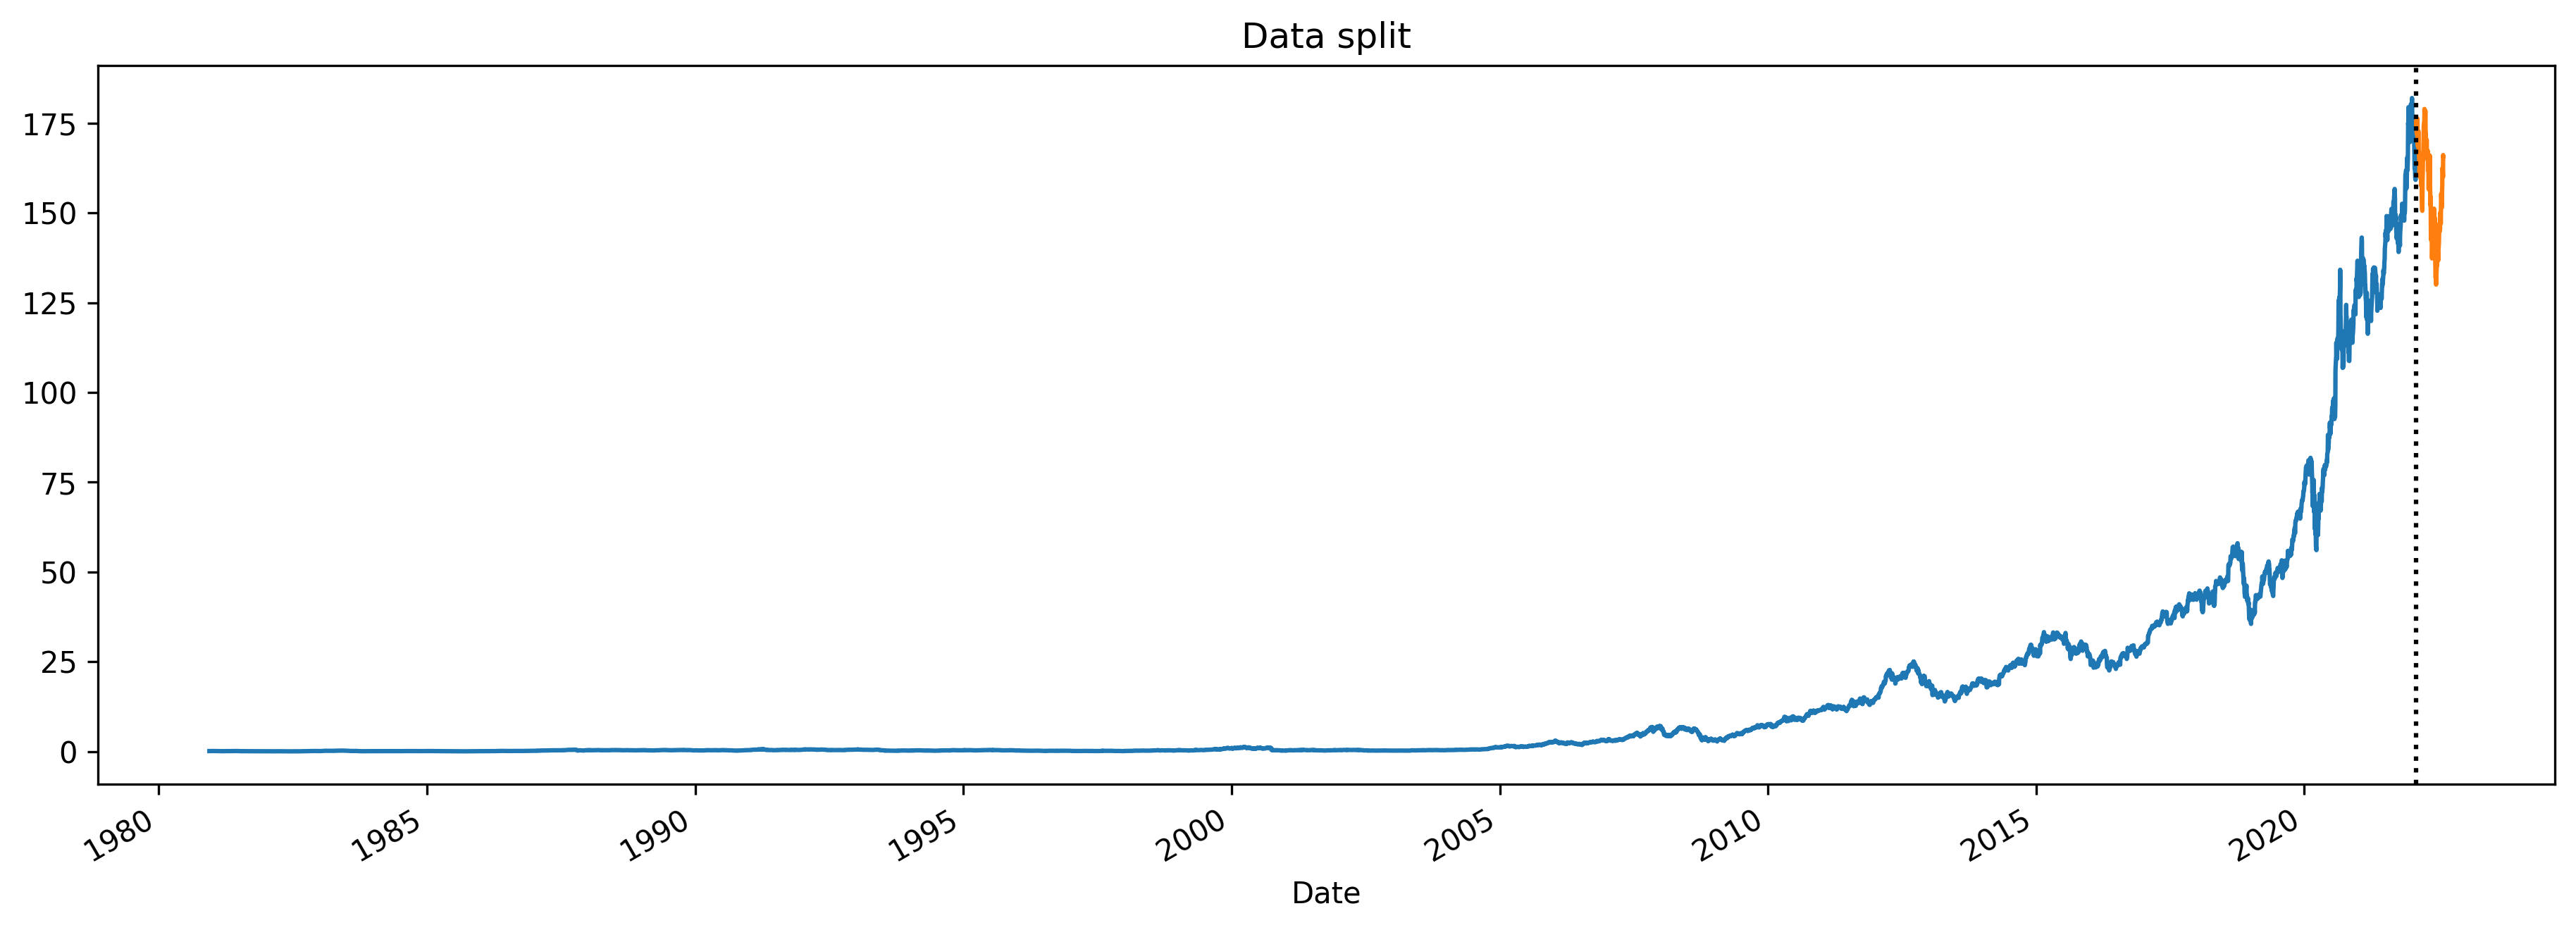

In [9]:
fig, ax = plt.subplots(figsize=(15,5))
train_data['Close'].plot(ax=ax, label='Train data', title="Data split")
test_data['Close'].plot(ax=ax, label='Test Data')
ax.axvline(data_split, color='black', ls='dotted')
plt.show()

<AxesSubplot:xlabel='Date'>

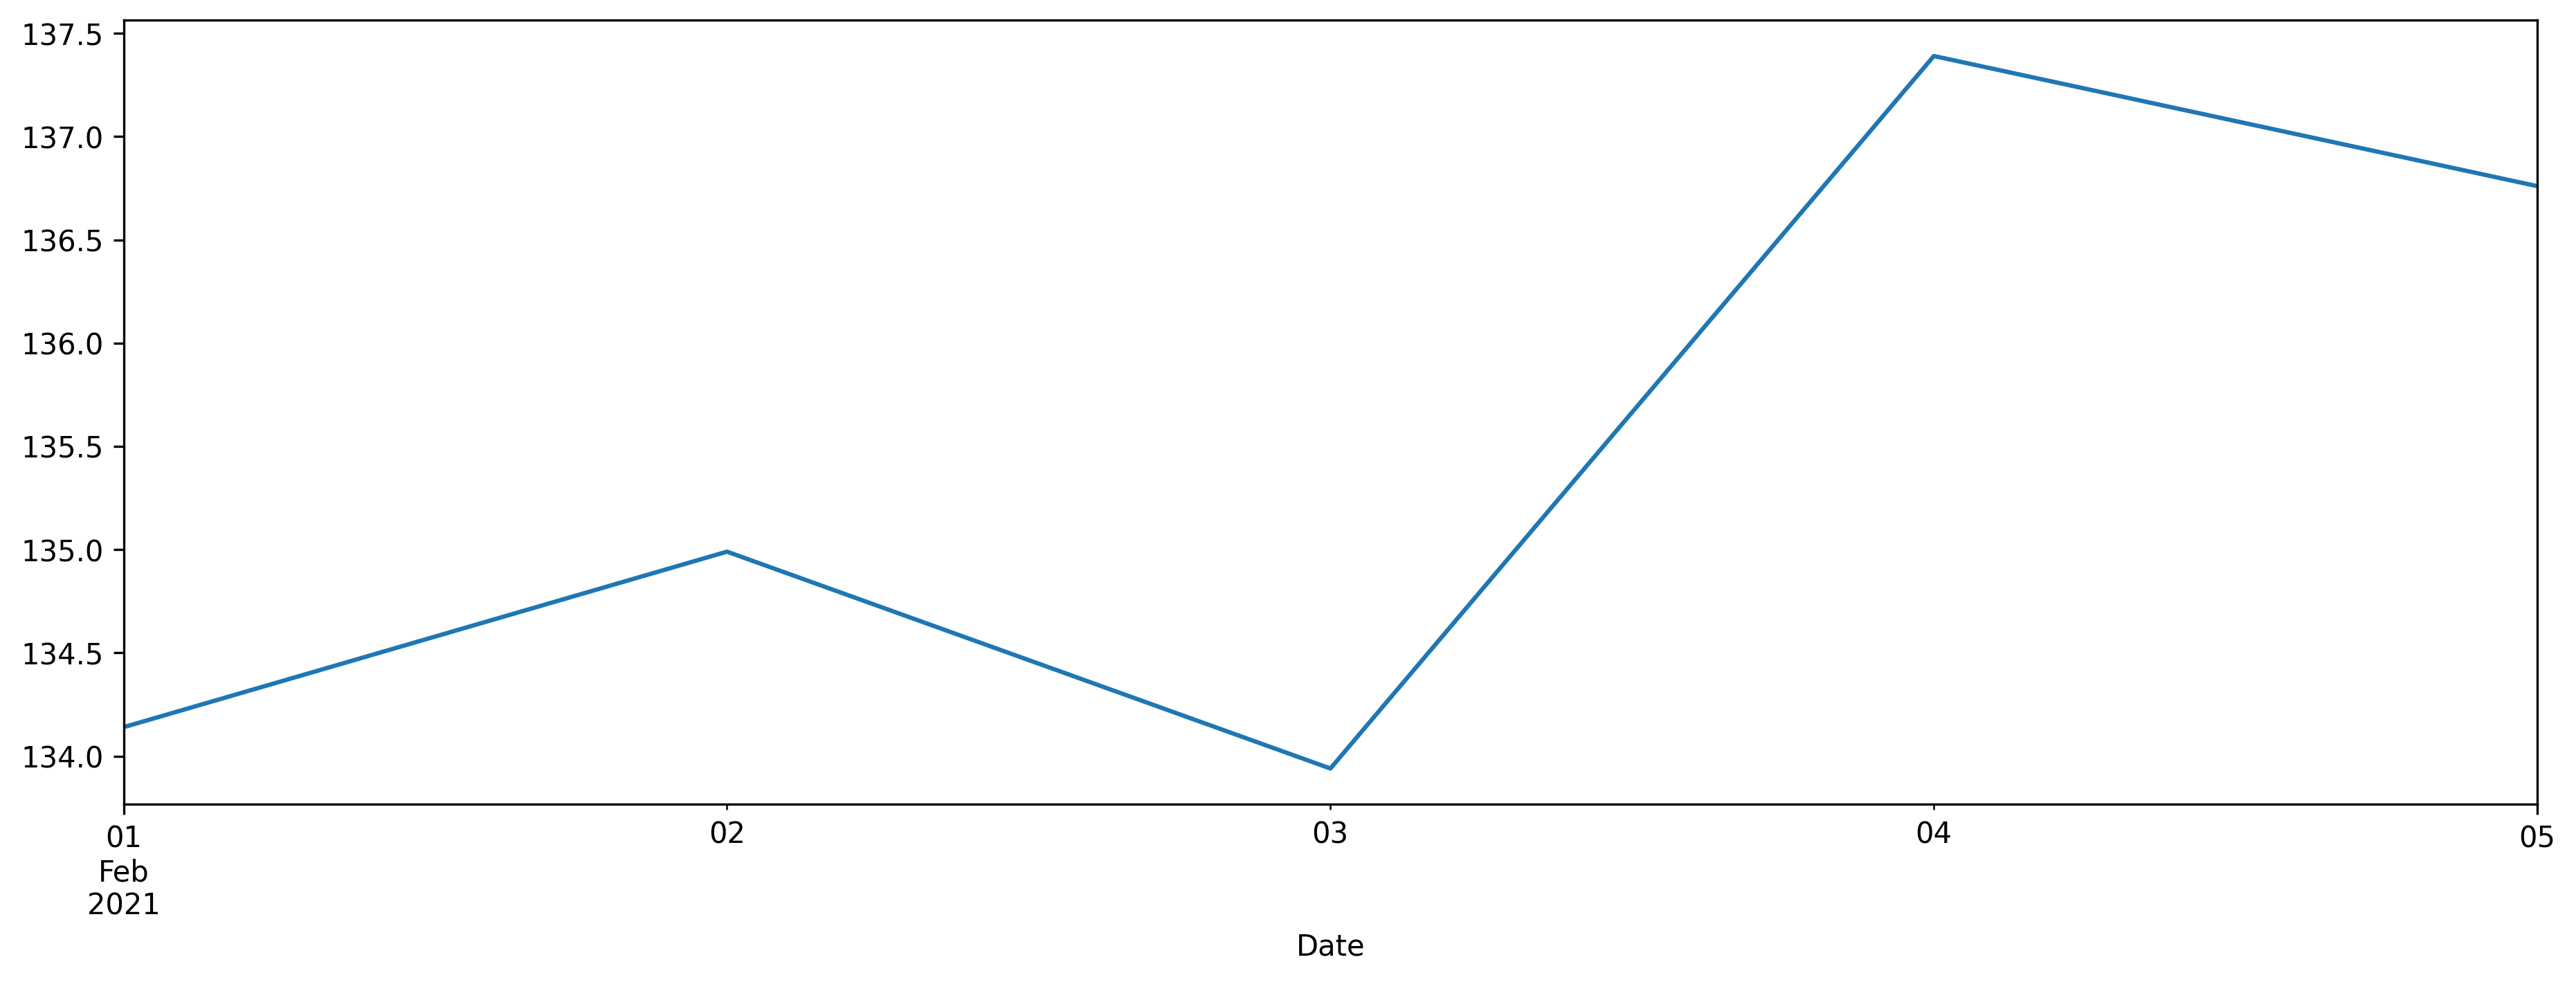

In [10]:
df['Close'].loc[(df.index  >= '02.01.2021') & (df.index <= '02.07.2021')].plot(figsize =(15,5))

In [11]:
def create_features(df):
    df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [12]:
df = create_features(df)

In [13]:
def show_distribution(feature):
    fig, ax = plt.subplots(figsize = (15, 5))
    sns.boxenplot(data=df, x=feature, y='Close')
    ax.set_title(f'Close by {feature}')
    plt.show()

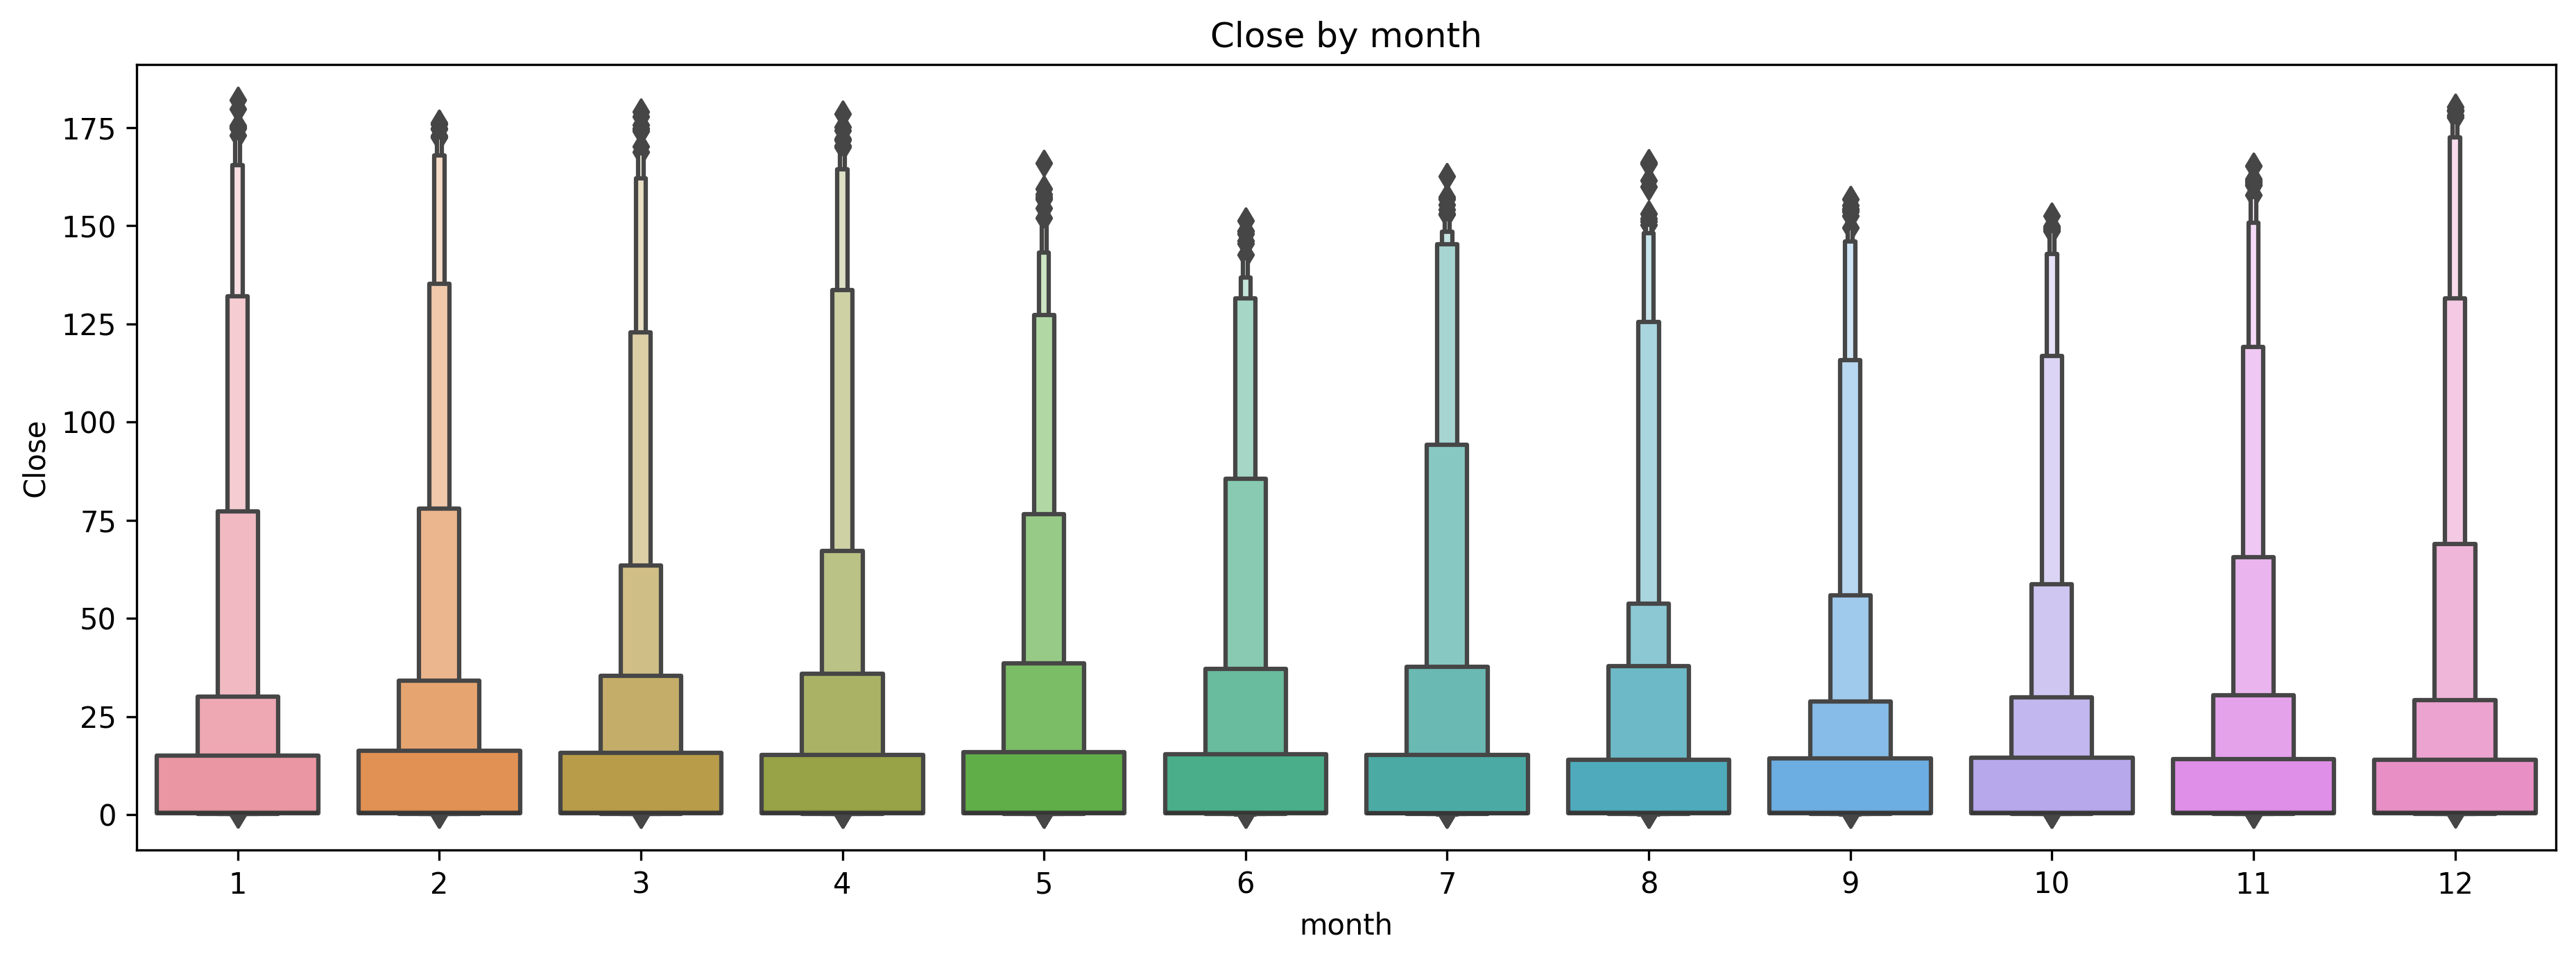

In [14]:
#monthly
show_distribution('month')

In [15]:
model = xgbreg(n_estimators=2000, 
                learning_rate=0.01,
                max_depth = 5,
                max_bin = 8192,
                predictor = 'gpu_predictor',
                objective = "reg:squarederror",
                early_stopping_rounds = 50,
                tree_method='gpu_hist' 
                )

In [16]:
df.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'dayofweek',
       'month', 'year', 'dayofyear'],
      dtype='object')

In [17]:
FEATURES = ['Open', 'High', 'Low', 'Volume', 'dayofweek', 'month', 'year', 'dayofyear']
TARGET = ['Close']
train = create_features(train_data)
test = create_features(test_data)

In [18]:
X_train = train[FEATURES]
X_test = test[FEATURES]
y_train = train[TARGET]
y_test = test[TARGET]

In [19]:
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=True
        )

[0]	validation_0-rmse:31.28915	validation_1-rmse:155.27213
[1]	validation_0-rmse:30.97954	validation_1-rmse:153.78145
[2]	validation_0-rmse:30.67302	validation_1-rmse:152.30572
[3]	validation_0-rmse:30.36956	validation_1-rmse:150.84468
[4]	validation_0-rmse:30.06912	validation_1-rmse:149.39734
[5]	validation_0-rmse:29.77169	validation_1-rmse:147.97746
[6]	validation_0-rmse:29.47723	validation_1-rmse:146.55975
[7]	validation_0-rmse:29.18570	validation_1-rmse:145.16813
[8]	validation_0-rmse:28.89709	validation_1-rmse:143.77850
[9]	validation_0-rmse:28.61136	validation_1-rmse:142.41449
[10]	validation_0-rmse:28.32848	validation_1-rmse:141.06655
[11]	validation_0-rmse:28.04843	validation_1-rmse:139.72918
[12]	validation_0-rmse:27.77117	validation_1-rmse:138.40336
[13]	validation_0-rmse:27.49665	validation_1-rmse:137.08382
[14]	validation_0-rmse:27.22488	validation_1-rmse:135.77909
[15]	validation_0-rmse:26.95583	validation_1-rmse:134.49154
[16]	validation_0-rmse:26.68944	validation_1-rmse:

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=8192, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=2000,
             n_jobs=0, num_parallel_tree=1, predictor='gpu_predictor',
             random_state=0, reg_alpha=0, reg_lambda=1, ...)

In [20]:
test_data['predictions'] = model.predict(X_test)

In [21]:
test_data.tail()

,High,Low,Open,Close,Volume,Adj Close,dayofweek,month,year,dayofyear,predictions
Date,,,,,,,,,,,
2022-07-29,163.630005,159.500000,161.240005,162.509995,101689200.0,162.509995,4,7,2022,210,161.247849
2022-08-01,163.589996,160.889999,161.009995,161.509995,67829400.0,161.509995,0,8,2022,213,161.721680
2022-08-02,162.410004,159.630005,160.100006,160.009995,59907000.0,160.009995,1,8,2022,214,161.527054
2022-08-03,166.589996,160.750000,160.839996,166.130005,82507500.0,166.130005,2,8,2022,215,163.645889
2022-08-04,167.190002,164.429993,166.009995,165.809998,55409400.0,165.809998,3,8,2022,216,162.910141


In [22]:
df = df.merge(test_data[['predictions']], how='left', left_index=True, right_index=True)

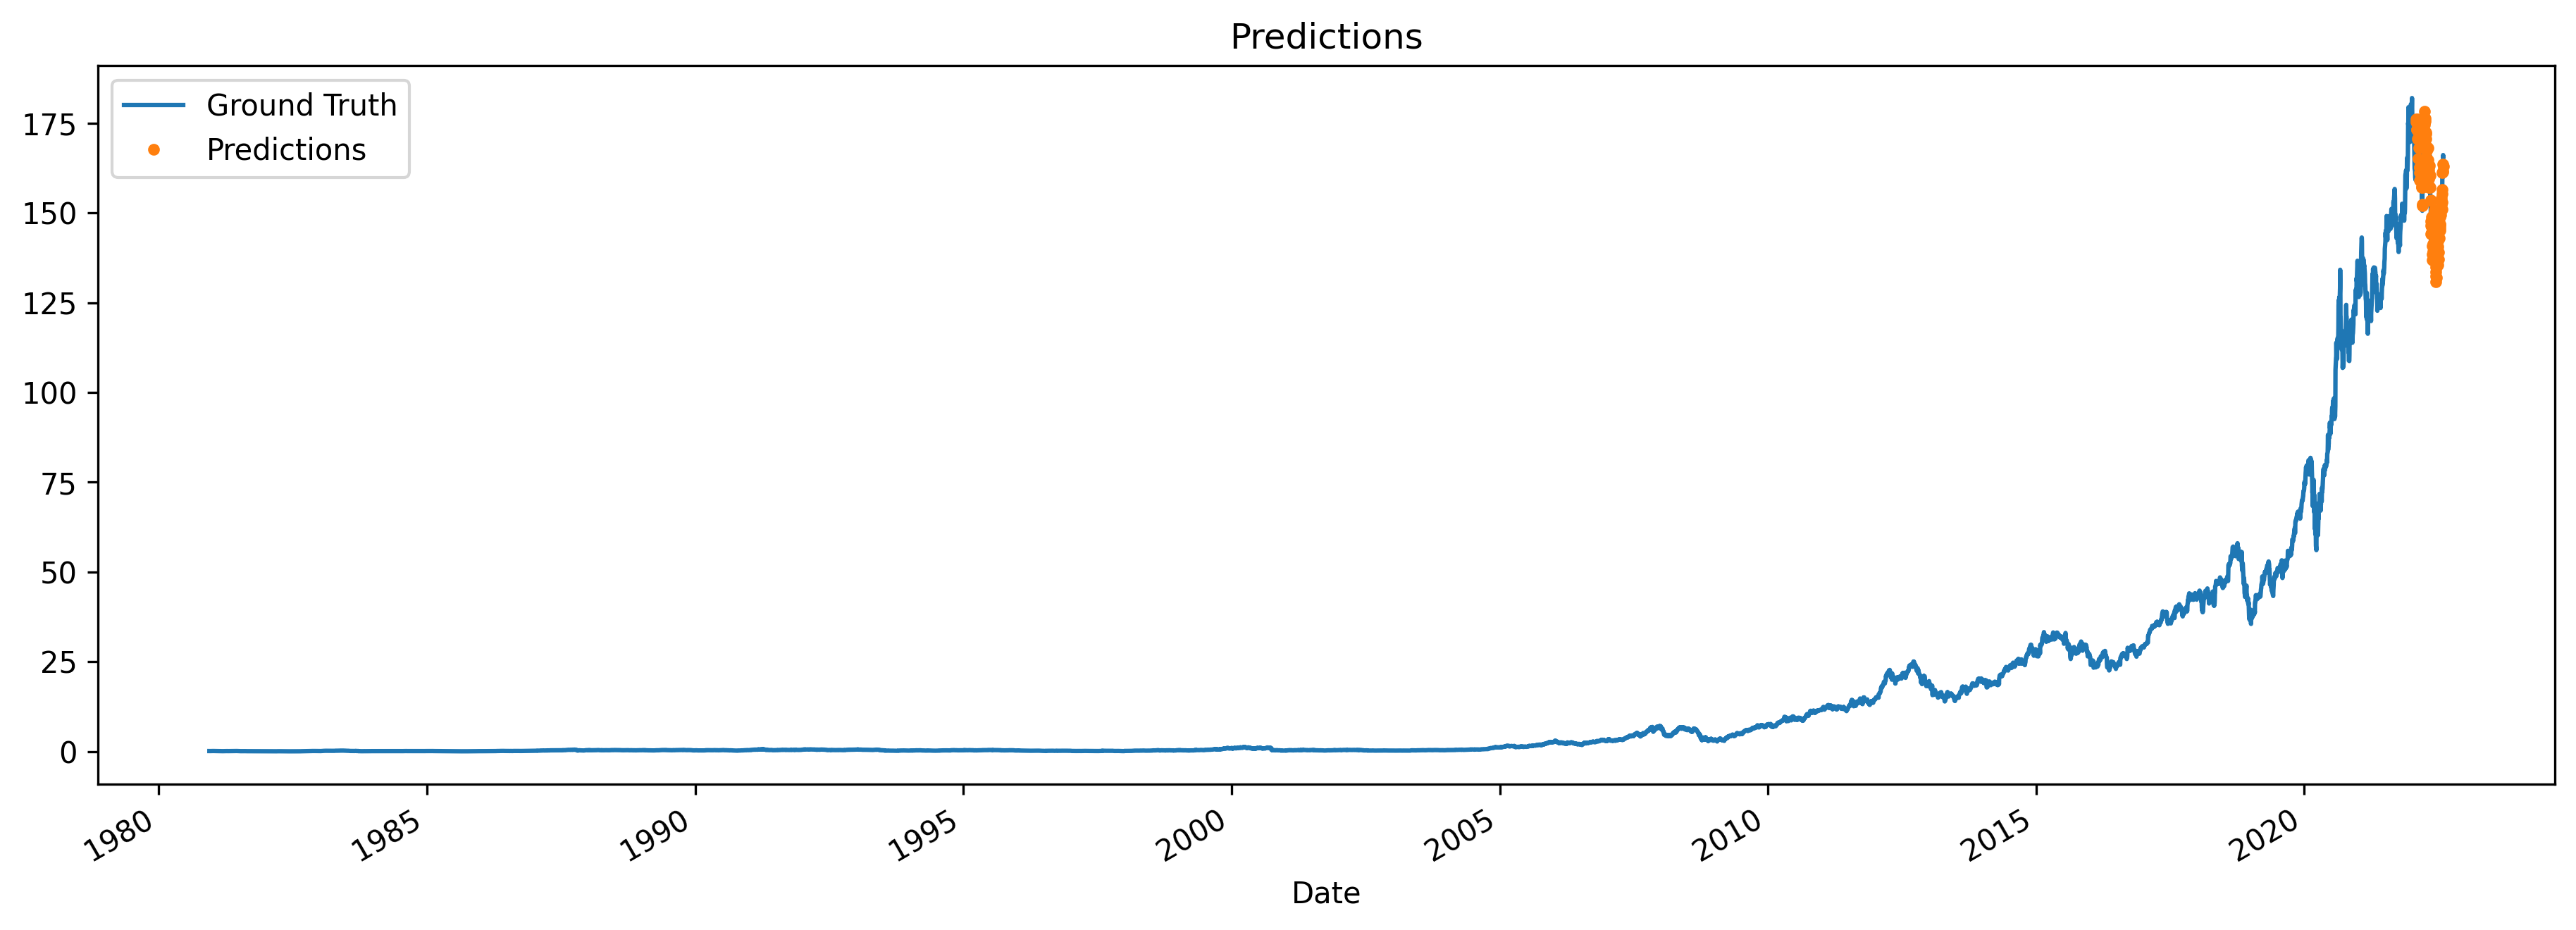

In [23]:
ax = df[['Close']].plot(figsize=(15,5))
df['predictions'].plot(ax=ax, style='.')
plt.legend(['Ground Truth', 'Predictions'])
ax.set_title('Predictions')
plt.show()

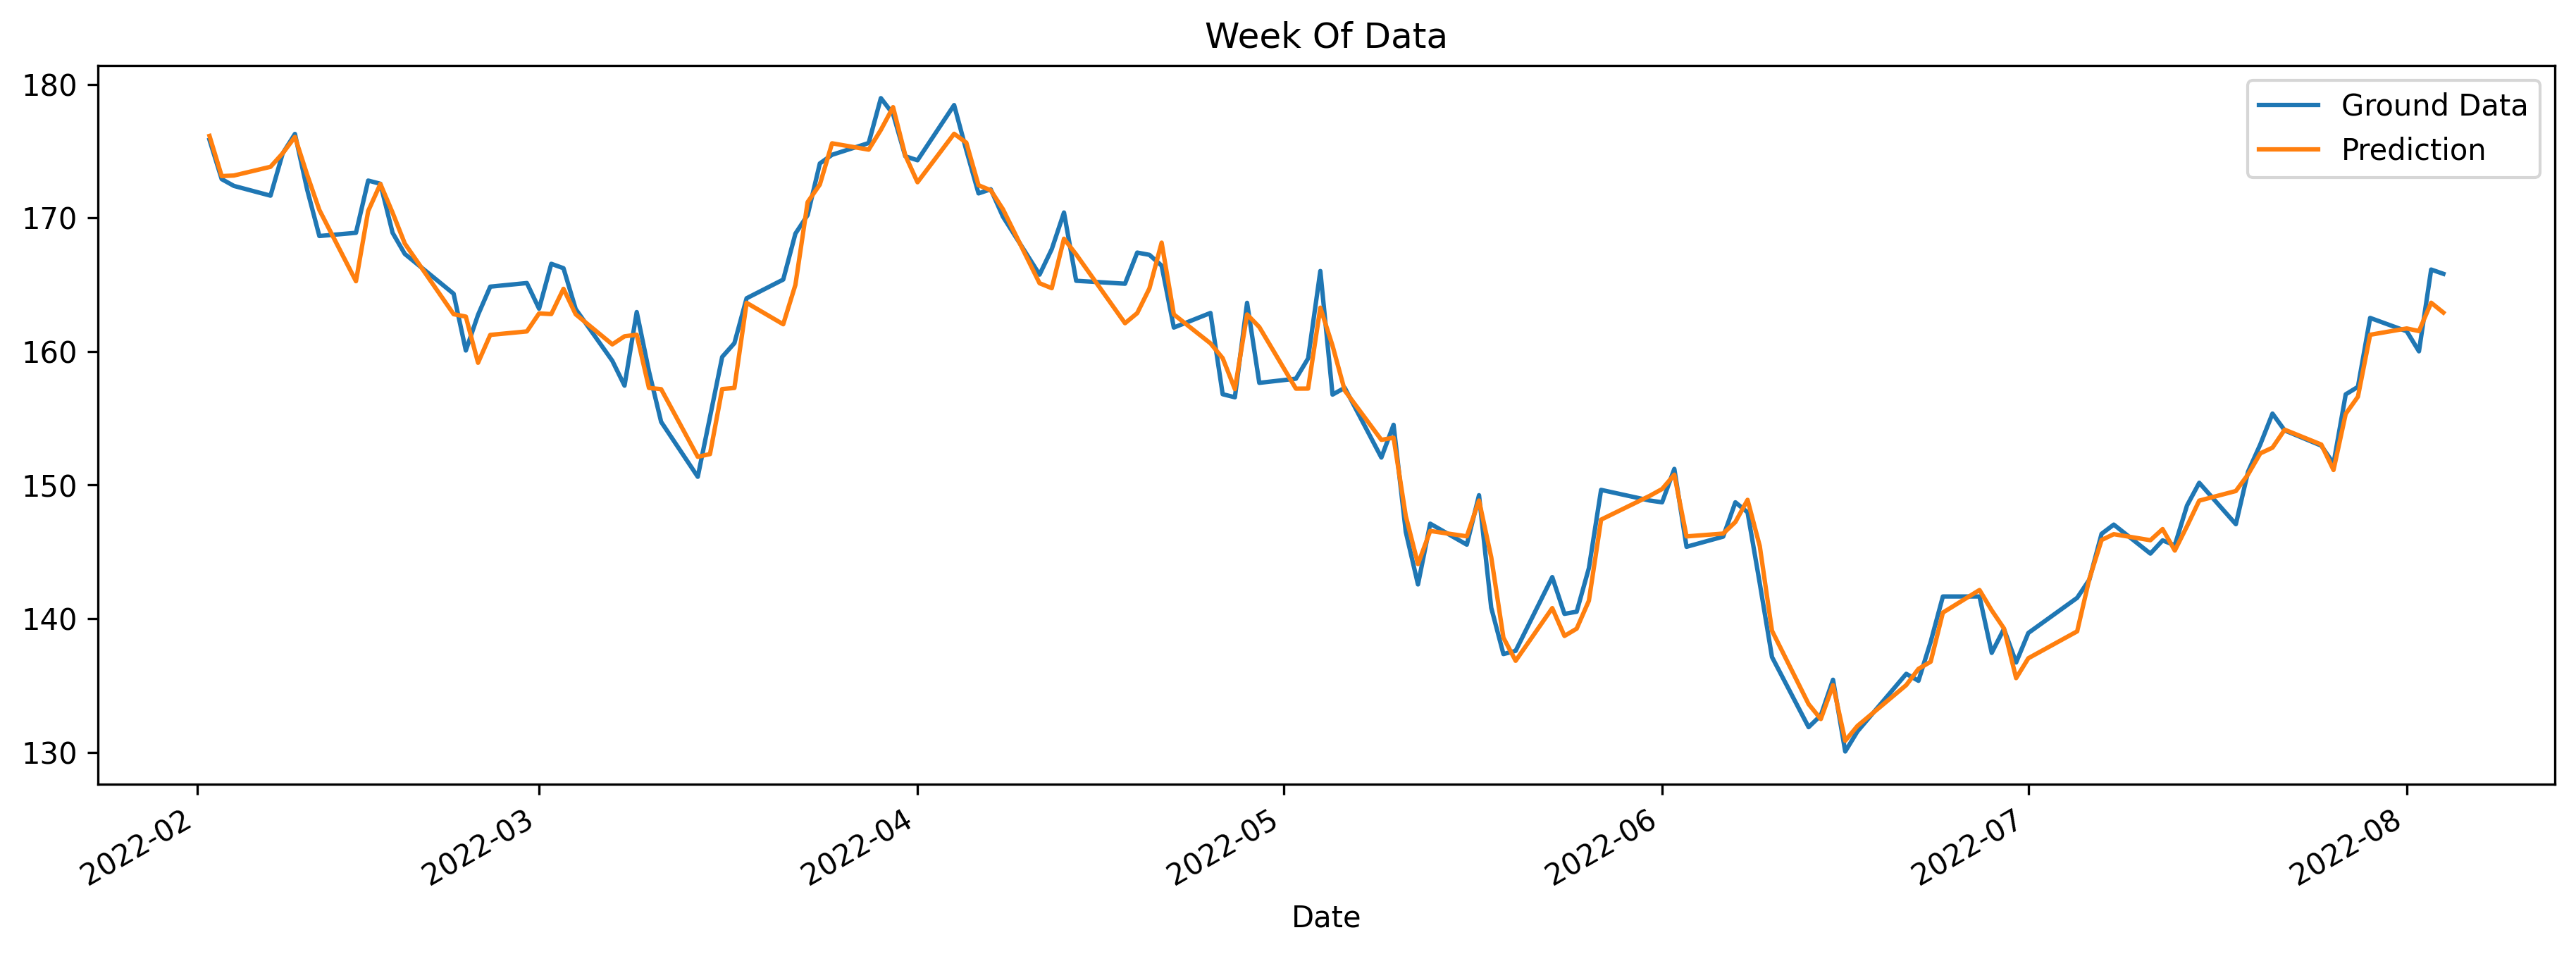

In [24]:
ax = df.loc[(df.index > data_split) & (df.index < dt.datetime.now())]['Close'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index >  data_split) & (df.index <  dt.datetime.now())]['predictions'] \
    .plot(style='-')
plt.legend(['Ground Data','Prediction'])
plt.show()

In [25]:
df.loc[(df.index > data_split) & (df.index < dt.datetime.now())].sort_values(by='Date', ascending=True).tail(60)

,High,Low,Open,Close,Volume,Adj Close,dayofweek,month,year,dayofyear,predictions
Date,,,,,,,,,,,
2022-05-10,156.740005,152.929993,155.520004,154.509995,115366700.0,154.509995,1,5,2022,130,153.546967
2022-05-11,155.449997,145.809998,153.500000,146.500000,142689800.0,146.500000,2,5,2022,131,147.688034
2022-05-12,146.199997,138.800003,142.770004,142.559998,182602000.0,142.559998,3,5,2022,132,144.087555
2022-05-13,148.100006,143.110001,144.589996,147.110001,113990900.0,147.110001,4,5,2022,133,146.566269
2022-05-16,147.520004,144.179993,145.550003,145.539993,86643800.0,145.539993,0,5,2022,136,146.161621
2022-05-17,149.770004,146.679993,148.860001,149.240005,78336300.0,149.240005,1,5,2022,137,148.842545
2022-05-18,147.360001,139.899994,146.850006,140.820007,109742900.0,140.820007,2,5,2022,138,144.602692
2022-05-19,141.660004,136.600006,139.880005,137.350006,136095600.0,137.350006,3,5,2022,139,138.572830
2022-05-20,140.699997,132.610001,139.089996,137.589996,137426100.0,137.589996,4,5,2022,140,136.847000


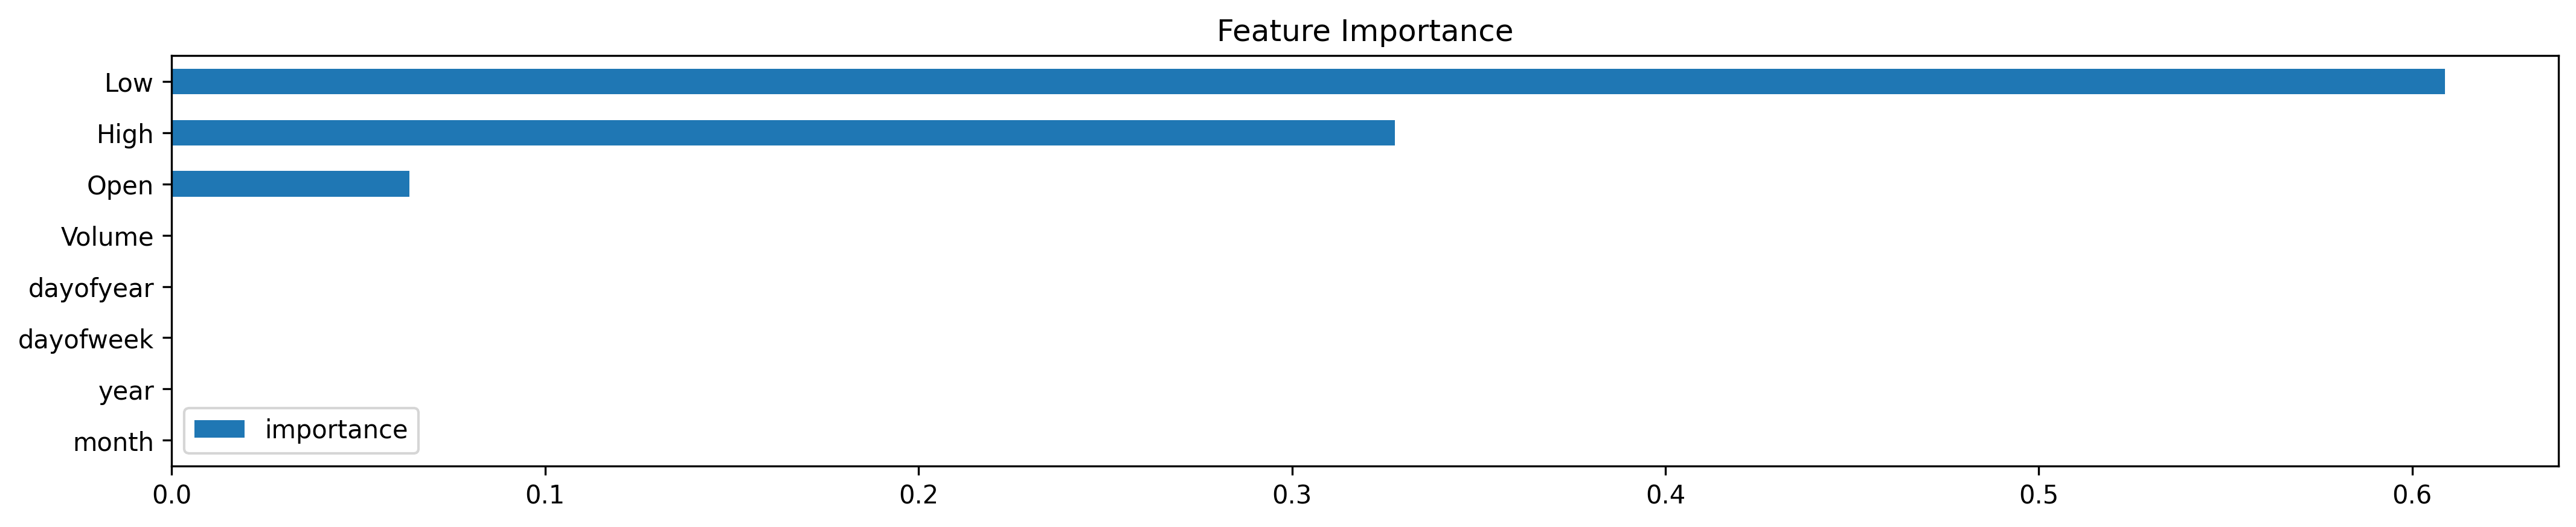

In [26]:
fi = pd.DataFrame(data=model.feature_importances_,
             index=model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [27]:
fi

,importance
Open,0.063630
High,0.327599
Low,0.608716
Volume,0.000014
dayofweek,0.000011
month,0.000008
year,0.000008
dayofyear,0.000013


In [28]:
df['Absolute_diff'] = df.apply(lambda x: abs(x['Close']- x['predictions']), axis=1)


In [29]:
df.loc[(df.index > data_split)].sort_values(by="Absolute_diff", ascending=True).head(20)

,High,Low,Open,Close,Volume,Adj Close,dayofweek,month,year,dayofyear,predictions,Absolute_diff
Date,,,,,,,,,,,,
2022-02-08,175.350006,171.429993,171.729996,174.830002,74829200.0,174.573502,1,2,2022,39,174.835800,0.005798
2022-02-16,173.339996,170.050003,171.850006,172.550003,61177400.0,172.296860,2,2,2022,47,172.535355,0.014648
2022-06-29,140.669998,136.669998,137.460007,139.229996,66242400.0,139.229996,2,6,2022,180,139.272217,0.042221
2022-07-22,156.279999,153.410004,155.389999,154.089996,66675400.0,154.089996,4,7,2022,203,154.143051,0.053055
2022-03-31,178.029999,174.399994,177.839996,174.610001,103049300.0,174.353836,3,3,2022,90,174.673630,0.063629
2022-07-06,144.119995,141.080002,141.350006,142.919998,74064300.0,142.919998,2,7,2022,187,142.985397,0.065399
2022-04-07,173.360001,169.850006,171.160004,172.139999,77594700.0,171.887451,3,4,2022,97,172.063980,0.076019
2022-07-25,155.039993,152.279999,154.009995,152.949997,53623900.0,152.949997,0,7,2022,206,153.032761,0.082764
2022-05-06,159.440002,154.179993,156.009995,157.279999,116124600.0,157.279999,4,5,2022,126,157.077316,0.202682


In [30]:
df.loc[(df.index > data_split) & (df.Absolute_diff > 1)].groupby(['month'], as_index=False)['Absolute_diff'].count()

,month,Absolute_diff
0,2,11
1,3,15
2,4,12
3,5,13
4,6,8
5,7,9
6,8,3


In [31]:
df.loc[(df.index > data_split) & (df.Absolute_diff < 1)].groupby(['month'], as_index=False)['Absolute_diff'].count()

,month,Absolute_diff
0,2,7
1,3,8
2,4,8
3,5,8
4,6,13
5,7,11
6,8,1


In [32]:
df.loc[(df.index > '2022-06-01') & (df.index <= '2022-06-30')]

,High,Low,Open,Close,Volume,Adj Close,dayofweek,month,year,dayofyear,predictions,Absolute_diff
Date,,,,,,,,,,,,
2022-06-02,151.270004,146.860001,147.830002,151.210007,72348100.0,151.210007,3,6,2022,153,150.775421,0.434586
2022-06-03,147.970001,144.460007,146.899994,145.380005,88570300.0,145.380005,4,6,2022,154,146.157486,0.777481
2022-06-06,148.570007,144.899994,147.029999,146.139999,71598400.0,146.139999,0,6,2022,157,146.368454,0.228455
2022-06-07,149.000000,144.100006,144.350006,148.710007,67808200.0,148.710007,1,6,2022,158,147.232834,1.477173
2022-06-08,149.869995,147.460007,148.580002,147.960007,53950200.0,147.960007,2,6,2022,159,148.893677,0.933670
2022-06-09,147.949997,142.529999,147.080002,142.639999,69473000.0,142.639999,3,6,2022,160,145.428711,2.788712
2022-06-10,140.759995,137.059998,140.279999,137.130005,91437900.0,137.130005,4,6,2022,161,139.097427,1.967422
2022-06-13,135.199997,131.440002,132.869995,131.880005,122207100.0,131.880005,0,6,2022,164,133.606033,1.726028
2022-06-14,133.889999,131.479996,133.130005,132.759995,84784300.0,132.759995,1,6,2022,165,132.486786,0.273209
